In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import audiomentations as AA

# Настройки
DATA_ROOT = "data"  
SAMPLE_RATE = 16000
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 64
N_CQT = 84
N_MFCC = 13

In [132]:
#augmenter = AA.Compose([
#    AA.AddGaussianNoise(p=0.5, min_amplitude=0.001, max_amplitude=0.015),
#    AA.TimeStretch(p=0.4, min_rate=0.8, max_rate=1.2),
#    AA.PitchShift(p=0.4, min_semitones=-2, max_semitones=2)
#])

augmenter = AA.Compose([
    AA.AddGaussianNoise(p=0.5, min_amplitude=0.001, max_amplitude=0.015),
    AA.TimeStretch(p=0.4, min_rate=0.8, max_rate=1.2),
    AA.PitchShift(p=0.4, min_semitones=-2, max_semitones=2),
    AA.Gain(p=0.3, min_gain_db=-10, max_gain_db=5),  # изменение громкости
    AA.Shift(p=0.2, min_shift=-0.1, max_shift=0.1, shift_unit="fraction")  # сдвиг по времени
])

In [133]:
def load_and_augment(filepath, augment=False):
    """Загрузка аудио и аугментация"""
    audio, sr = librosa.load(filepath, sr=SAMPLE_RATE)
    if augment and augmenter:
        audio = augmenter(samples=audio, sample_rate=sr)
    return audio, sr

def extract_features(audio, sr, max_frames=200):  # фиксируем max_frames
    # Mel-спектрограмма
    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )
    mel = librosa.power_to_db(mel, ref=np.max)
    
    # CQT
    cqt = np.abs(librosa.cqt(
        y=audio, sr=sr, hop_length=HOP_LENGTH, n_bins=N_CQT
    ))
    cqt = librosa.amplitude_to_db(cqt, ref=np.max)
    
    # MFCC + Delta
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    delta = librosa.feature.delta(mfcc)
    mfcc_delta = np.vstack([mfcc, delta])  
    
    # Объединение
    features = np.vstack([mel, cqt, mfcc_delta])  
    features = (features - features.mean()) / (features.std() + 1e-8)
    
    # Padding до max_frames по времени
    T = features.shape[1]
    if T < max_frames:
        pad_width = ((0, 0), (0, max_frames - T))
        features = np.pad(features, pad_width, mode='constant', constant_values=0)
    elif T > max_frames:
        features = features[:, :max_frames]  # обрезка

    return features.T 


barbie_files = [os.path.join(DATA_ROOT, "barbie", f) for f in os.listdir(os.path.join(DATA_ROOT, "barbie"))]
puppy_files = [os.path.join(DATA_ROOT, "puppy", f) for f in os.listdir(os.path.join(DATA_ROOT, "puppy"))]

all_files = barbie_files + puppy_files
all_labels = [0] * len(barbie_files) + [1] * len(puppy_files)  # 0=barbie, 1=puppy


train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)


In [134]:
def create_dataset(file_list, label_list, augment=False, max_frames=200):
    X, y = [], []
    for filepath, label in tqdm(zip(file_list, label_list), total=len(file_list)):
        audio, sr = load_and_augment(filepath, augment=augment)
        features = extract_features(audio, sr, max_frames=max_frames)
        X.append(features)  
        y.append(label)
    return np.array(X), np.array(y)  



max_frames = 200 

X_train, y_train = create_dataset(train_files, train_labels, augment=True, max_frames=max_frames)
X_val, y_val = create_dataset(val_files, val_labels, augment=False, max_frames=max_frames)

print("X_train shape:", X_train.shape)  
print("X_val shape:", X_val.shape)    


100%|██████████| 20/20 [00:00<00:00, 25.09it/s]

X_train shape: (78, 200, 174)
X_val shape: (20, 200, 174)


In [135]:
def create_mlp_model(input_shape, hidden_dim=256, num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape), 
        
        
        layers.GlobalAveragePooling1D(),
        
        
        layers.Dense(hidden_dim, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(hidden_dim // 2, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax') 
    ])
    
    #model = models.Sequential([
    #    layers.Input(shape=(max_frames, 174)),
    #    layers.Conv1D(64, 3, activation='relu'),
    #    layers.BatchNormalization(),
    #    layers.Dropout(0.3),
    #    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    #    layers.Dense(32, activation='relu'),
    #    layers.BatchNormalization(),
    #    layers.Dropout(0.4),
    #    layers.Dense(2, activation='softmax')
    #])
    return model


input_shape = (X_train.shape[1], X_train.shape[2]) 
model = create_mlp_model(input_shape, hidden_dim=256, num_classes=2)


model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d_8      │ (None, 174)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │        44,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,490 (310.51 KB)

 Trainable params: 78,722 (307.51 KB)

 Non-trainable params: 768 (3.00 KB)

In [136]:

callbacks = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=5),
    callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2500 - loss: 1.7734

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.4231 - loss: 1.4117 - val_accuracy: 0.5000 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5513 - loss: 1.0929 - val_accuracy: 0.5500 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 0.9936

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5641 - loss: 0.9050 - val_accuracy: 0.5500 - val_loss: 0.6866 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5513 - loss: 0.9821 - val_accuracy: 0.5000 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6538 - loss: 0.7363 - val_accuracy: 0.5000 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6410 - loss: 0.8148 - val_accuracy: 0.5000 - val_loss: 0.6971 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7179 - loss: 0.7048 - val_accuracy: 0.5000 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6923 - loss: 0.6479 - val_accuracy: 0.5000 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 9/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 1.0345

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6154 - loss: 0.7968 - val_accuracy: 0.5000 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 10/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 0.9810

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6154 - loss: 0.7713 - val_accuracy: 0.5000 - val_loss: 0.6844 - learning_rate: 1.0000e-04
Epoch 11/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - loss: 0.5865

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8205 - loss: 0.5229 - val_accuracy: 0.5000 - val_loss: 0.6826 - learning_rate: 1.0000e-04
Epoch 12/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 0.9550

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7051 - loss: 0.7070 - val_accuracy: 0.5000 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 13/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.5121

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6410 - loss: 0.6750 - val_accuracy: 0.5000 - val_loss: 0.6813 - learning_rate: 1.0000e-04
Epoch 14/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4375 - loss: 1.2898

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6795 - loss: 0.7070 - val_accuracy: 0.5000 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 15/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.7990

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6923 - loss: 0.7087 - val_accuracy: 0.5000 - val_loss: 0.6799 - learning_rate: 1.0000e-04
Epoch 16/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5000 - loss: 1.0017

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6795 - loss: 0.7283 - val_accuracy: 0.5000 - val_loss: 0.6794 - learning_rate: 1.0000e-04
Epoch 17/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6250 - loss: 1.0082

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6795 - loss: 0.8117 - val_accuracy: 0.5000 - val_loss: 0.6771 - learning_rate: 1.0000e-04
Epoch 18/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.5248

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6282 - loss: 0.6856 - val_accuracy: 0.5000 - val_loss: 0.6765 - learning_rate: 1.0000e-04
Epoch 19/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.5302

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7564 - loss: 0.4911 - val_accuracy: 0.5000 - val_loss: 0.6762 - learning_rate: 1.0000e-04
Epoch 20/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6875 - loss: 0.6159

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.4558 - val_accuracy: 0.5000 - val_loss: 0.6750 - learning_rate: 1.0000e-04
Epoch 21/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 1.0268

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6410 - loss: 0.6892 - val_accuracy: 0.5000 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 22/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8125 - loss: 0.5161

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7179 - loss: 0.6023 - val_accuracy: 0.5000 - val_loss: 0.6705 - learning_rate: 1.0000e-04
Epoch 23/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6250 - loss: 0.7621

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6282 - loss: 0.7604 - val_accuracy: 0.5000 - val_loss: 0.6677 - learning_rate: 1.0000e-04
Epoch 24/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.4869

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6923 - loss: 0.5966 - val_accuracy: 0.5000 - val_loss: 0.6651 - learning_rate: 1.0000e-04
Epoch 25/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6250 - loss: 0.6914

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6795 - loss: 0.6332 - val_accuracy: 0.5000 - val_loss: 0.6630 - learning_rate: 1.0000e-04
Epoch 26/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.5487

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7179 - loss: 0.5265 - val_accuracy: 0.5000 - val_loss: 0.6607 - learning_rate: 1.0000e-04
Epoch 27/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - loss: 0.5639

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7436 - loss: 0.5808 - val_accuracy: 0.5000 - val_loss: 0.6593 - learning_rate: 1.0000e-04
Epoch 28/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5625 - loss: 1.0642

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7564 - loss: 0.5761 - val_accuracy: 0.5000 - val_loss: 0.6569 - learning_rate: 1.0000e-04
Epoch 29/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8125 - loss: 0.3565

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6538 - loss: 0.6203 - val_accuracy: 0.5000 - val_loss: 0.6539 - learning_rate: 1.0000e-04
Epoch 30/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5625 - loss: 0.8274

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6538 - loss: 0.6157 - val_accuracy: 0.5000 - val_loss: 0.6512 - learning_rate: 1.0000e-04
Epoch 31/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6875 - loss: 0.6195

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 0.7153 - val_accuracy: 0.5000 - val_loss: 0.6484 - learning_rate: 1.0000e-04
Epoch 32/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7500 - loss: 0.6069

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7436 - loss: 0.5425 - val_accuracy: 0.5500 - val_loss: 0.6447 - learning_rate: 1.0000e-04
Epoch 33/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8125 - loss: 0.4418

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7821 - loss: 0.5218 - val_accuracy: 0.5500 - val_loss: 0.6429 - learning_rate: 1.0000e-04
Epoch 34/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6875 - loss: 0.5174

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7308 - loss: 0.5332 - val_accuracy: 0.6000 - val_loss: 0.6402 - learning_rate: 1.0000e-04
Epoch 35/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6875 - loss: 0.5911

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6538 - loss: 0.7285 - val_accuracy: 0.6000 - val_loss: 0.6357 - learning_rate: 1.0000e-04
Epoch 36/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7500 - loss: 0.6795

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7179 - loss: 0.6549 - val_accuracy: 0.6000 - val_loss: 0.6323 - learning_rate: 1.0000e-04
Epoch 37/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8125 - loss: 0.5714

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7179 - loss: 0.6315 - val_accuracy: 0.6000 - val_loss: 0.6297 - learning_rate: 1.0000e-04
Epoch 38/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6875 - loss: 0.6882

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6667 - loss: 0.6833 - val_accuracy: 0.6000 - val_loss: 0.6269 - learning_rate: 1.0000e-04
Epoch 39/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6250 - loss: 0.7058

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6538 - loss: 0.5620 - val_accuracy: 0.7000 - val_loss: 0.6233 - learning_rate: 1.0000e-04
Epoch 40/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7500 - loss: 0.5178

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7949 - loss: 0.5215 - val_accuracy: 0.7000 - val_loss: 0.6206 - learning_rate: 1.0000e-04
Epoch 41/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6875 - loss: 0.6962

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7308 - loss: 0.6161 - val_accuracy: 0.7000 - val_loss: 0.6185 - learning_rate: 1.0000e-04
Epoch 42/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7500 - loss: 0.4681

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7821 - loss: 0.4648 - val_accuracy: 0.6500 - val_loss: 0.6168 - learning_rate: 1.0000e-04
Epoch 43/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8750 - loss: 0.6086

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8462 - loss: 0.4283 - val_accuracy: 0.6500 - val_loss: 0.6150 - learning_rate: 1.0000e-04
Epoch 44/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 0.6939

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6410 - loss: 0.6764 - val_accuracy: 0.6500 - val_loss: 0.6128 - learning_rate: 1.0000e-04
Epoch 45/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.8153

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7179 - loss: 0.5854 - val_accuracy: 0.6000 - val_loss: 0.6106 - learning_rate: 1.0000e-04
Epoch 46/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8125 - loss: 0.4221

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7821 - loss: 0.5612 - val_accuracy: 0.6000 - val_loss: 0.6093 - learning_rate: 1.0000e-04
Epoch 47/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6875 - loss: 0.8256

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7308 - loss: 0.5313 - val_accuracy: 0.7000 - val_loss: 0.6064 - learning_rate: 1.0000e-04
Epoch 48/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8750 - loss: 0.3716

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8077 - loss: 0.4084 - val_accuracy: 0.7000 - val_loss: 0.6053 - learning_rate: 1.0000e-04
Epoch 49/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - loss: 0.8761

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7179 - loss: 0.6286 - val_accuracy: 0.7000 - val_loss: 0.6044 - learning_rate: 1.0000e-04
Epoch 50/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.6549

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7179 - loss: 0.6228 - val_accuracy: 0.7000 - val_loss: 0.6029 - learning_rate: 1.0000e-04


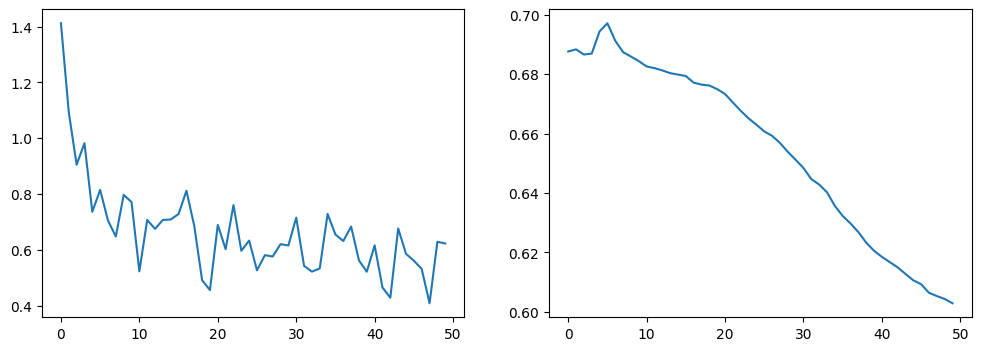

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')